# Exploring the Link between DDPMs, SDE, and Optimal Transport

**Denoising diffusion probabilistic models (DDPMs)** have recently gained significant attention for their ability to model complex distributions, particularly in tasks such as image synthesis. A key aspect of understanding DDPMs lies in analyzing their latent codes, which play a crucial role in generating realistic samples.

The paper titled *[Understanding DDPM Latent Codes through Optimal Transport](https://arxiv.org/abs/2202.07477)* (Khrulkov 2022) provides insights into this aspect by exploring the relationship between DDPM latent codes and optimal transport theory. By analyzing the optimal transport map between the data distribution and the standard normal distribution, the paper sheds light on the geometric properties of DDPM latent codes. Through extensive numerical experiments and theoretical analysis, the authors demonstrate that the **DDPM encoder map** closely approximates the **Monge map** associated with optimal transport, especially for common distributions.

In this document, we explain the main results and try to reimplement the findings of this paper.

## Background

### Denoising Diffusion Probabilistic Models

DDPMs are generative models that utilize a forward diffusion process to transform clean data into Gaussian distributions by gradually adding noise. The generative model then learns to reverse this process, producing realistic samples from noise. The forward process is described by the transition probabilities:

$$
q(x_{t}|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t I)
$$

where $\beta\_1, \dots, \beta_t$ represent the variance schedule. The generative model learns parameterized Gaussian transitions, given by:

$$
p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_t; a_{\theta}(x_t, t), \sigma_t)
$$

A key component of DDPMs is the incorporation of a score function, which guides the generative process by approximating the gradients of the log-density of the target distribution. This score function, denoted as $s_{\theta}(x_t, t)$, where $\theta$ represents the model parameters, plays a crucial role in both training and sampling from the model. Mathematically, the score function is defined as:

$$
s_{\theta}(x_t, t) = \frac{\epsilon_{\theta}(x_t, t)}{\sqrt{1 - \bar{\alpha}_t}}
$$

where $\epsilon_{\theta}(x_t, t)$ is the noise predictor network predicting the noise component from the sample $x_t$ and step $t$, and $\bar{\alpha}_t$ represents the product of decay factors up to step $t$.

In practice, DDPMs offer both *stochastic and deterministic sampling* techniques. Stochastic sampling involves generating noisy samples from the current state using the score function and random noise, capturing the inherent uncertainty in the generative process. Mathematically, stochastic sampling is expressed as:

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( x_{t} - \frac{1 - \alpha_{t}}{\sqrt{1 - \bar{\alpha}_{t}}} \epsilon_{\theta}(x_{t}, t) \right) + \sigma_{t} \mathbf{z}
$$

where $x_{t-1}$ represents the noisy sample at time $t-1$, $\mathbf{z}$ is sampled from a standard normal distribution, and $\sigma_{t}$ represents the scale of the noise.

Conversely, deterministic sampling, as proposed in variants like DDIM (Denoising Diffusion Implicit Model), provides a deterministic approach to sample from the target distribution without the need for retraining. Mathematically, DDIM sampling is expressed as:

$$
x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} \left( \frac{x_{t} - \sqrt{1 - \bar{\alpha}_{t}} \epsilon_{\theta}(x_{t}, t)}{\sqrt{\bar{\alpha}_{t}}} \right) + \sqrt{1-\bar{\alpha}_{t-1}} \cdot \epsilon_{\theta}(x_{t}, t)7
$$

By integrating these sampling techniques with the theoretical framework of Stochastic Differential Equations (SDEs), DDPMs offer a versatile and effective approach to generative modeling.


### Stochastic Differential Equations

The authors of [Meng et al. (2021)](https://arxiv.org/abs/2108.01073) proposed viewing diffusion models as discretizations of certain SDEs. For instance, the continuous analogue of DDIM sampling is constructed through the **probability flow ODE**:

$$
dx = -\frac{\beta(t)}{2} \left[x + \nabla_x \log p_t(x) \right] dt
$$

This ODE results in the same marginal distributions $p_t$ as given by the SDE. The score function $\nabla_x \log p_t(x)$ is approximated via a neural network during training. Reversing this ODE provides a mapping from the limiting distribution to the data distribution, indicating that DDIM sampling is a discretization of this continuous approach.

The *Fokker-Planck equation* determines how a density $p_0$ evolves under a (general) SDE. For the SDE provided, it takes the form:

$$
\frac{\partial p_t}{\partial t} = \frac{\beta(t)}{2} \left[ \nabla_x \cdot (x p_t) + \nabla^2_x p_t \right]
$$

Solving this equation yields the probability flow ODE, which can be simplified to:

$$
dx = -\left[ x + \nabla_x \log p_t(x) \right] dt
$$

## Relationship with Optimal Transport

In the paper, the authors investigate how the DDPM encoder map relates to optimal transport (OT) theory, particularly focusing on the Monge map.

### Monge Map

The Monge formulation seeks to find a transport map $S: X \rightarrow Y$ that directly maps points from one distribution to another while minimizing the transportation cost. Mathematically, this involves finding $S$ such that $\int c(x, S(x)) \mu(x) \, dx$ is minimized over all transport maps $S$ such that $\nu = S_{\#} \mu$, where $S_{\#} \mu$ denotes the push-forward measure of $\mu$ under $S$.


### DDPM encoder map

The encoder map of DDPMs is a key component responsible for mapping data distributions to a standard normal distribution. The encoder map is obtained by considering the probability flow ODE. For a given distribution $\mu_0$ and a timestep $t$, the flow generated by this vector field is denoted as $E_{\mu_0}(t, \cdot)$. The final encoding map is obtained when $t \rightarrow \infty$, defined as:

$$
E_{\mu_0}(x) := \lim_{t \rightarrow \infty} E_{\mu_0}(t, x)
$$

### DDPM encoder and OT (Theorem 3.1 of the paper)

The paper explores the relationship between the DDPM encoder map and the Monge map associated with optimal transport. Specifically, it investigates whether the DDPM encoder map performs an optimal transformation that minimizes the transportation cost between the data distribution and the standard normal distribution.

**Theorem 3.1** in the paper provides a theoretical foundation for understanding the relationship between the DDPM encoder map and the Monge map :

Given a multivariate normal distribution $\mu_0$ with mean vector $a(0)$ and covariance matrix $\Sigma(0)$, Theorem 3.1 establishes that the DDPM encoder map $E_{\mu_0}$ coincides with the Monge optimal transport map between $\mu_0$ and the standard normal distribution $\mathcal{N}(0, I)$. In other words, the encoder map $E_{\mu_0}(x)$ is equivalent to $\Sigma(0)^{-1/2}(x - a(0))$.

Let $X$ represent the data space, $Z$ denote the latent space, and $\mathcal{N}(0, I)$ denote the standard normal distribution. The goal is to find the optimal mapping $E_{\mu_0}: X \rightarrow Z$ that minimizes the transportation cost between the data distribution $\mu_0$ and the standard normal distribution.

The transportation cost $C(E_{\mu_0})$ is defined as the integral of the cost function $c(x, E_{\mu_0}(x))$ with respect to the density of $\mu_0$:
$$
C(E_{\mu_0}) = \int_{X} c(x, E_{\mu_0}(x)) \mu_0(x) \, dx
$$

The Monge map $S$ minimizes this transportation cost:
$$
S = \arg \min_{E_{\mu_0}} C(E_{\mu_0})
$$

Theorem 3.1 asserts that **the DDPM encoder map $E_{\mu_0}$ achieves this minimum transportation cost, aligning with the Monge optimal transport map**.

## Numerical experiments on synthetic data

To illustrate the result of the Theorem 3.1, we can compare the Monge optimal transport map and the DDPM encoder map on 2d multivariate normal distributions. Given $\mu \sim \mathcal{N}(a,I_2)$ where $a\in \mathbb{R}^2$, we compute the Monge optimal transport map and the DDMP encoder map between $\mu$ and a reduced centered normal law $\mathcal{N}(0,I_2)$. 

First, lets draw some points according to $\mu \sim \mathcal{N}(a,I_2)$

In [1]:
import jax
import jax.random as jrd
import jax.numpy as jnp

key = jrd.PRNGKey(42)

mean = jnp.array([-10, -5.0]) 
covariance = jnp.array([[1.0, 0.], [0., 1.0]])
n_points = 10000

datapoints = jrd.multivariate_normal(key, mean, covariance, shape=(n_points,))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


We can plot these points: 

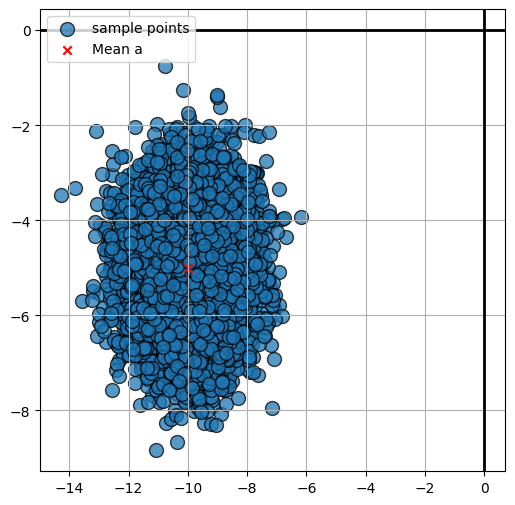

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(datapoints[:, 0], datapoints[:, 1], s=100, label="sample points", edgecolor="k", alpha=0.75)
plt.axhline(0, color='black', linewidth=2)
plt.axvline(0, color='black', linewidth=2)
plt.scatter(-10, -5, color='red', marker='x', label='Mean a')
plt.legend()
plt.grid(True)
plt.show()

For the Monge optimal transport map, we use the Sinkhorn algorithm. 

In [3]:
import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.solvers import linear

mean_target = jnp.array([0, 0])
covariance_target = jnp.eye(2)

target = jrd.multivariate_normal(key, mean_target, covariance_target, shape=(n_points,))

geom = pointcloud.PointCloud(datapoints, target)

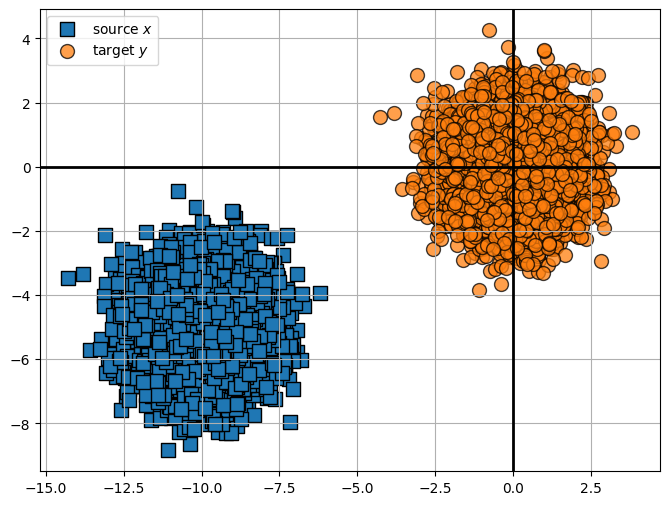

In [25]:
x_args = {"s": 100, "label": r"target $y$", "edgecolor": "k", "alpha": 0.75}
y_args = {"s": 100, "label": r"source $x$", "marker": "s", "edgecolor": "k"}
plt.figure(figsize=(8, 6))
plt.scatter(datapoints[:, 0], datapoints[:, 1], **y_args)
plt.scatter(target[:, 0], target[:, 1], **x_args)
plt.axhline(0, color='black', linewidth=2)
plt.axvline(0, color='black', linewidth=2)
plt.legend()
plt.grid(True)
plt.show()

In [17]:
def plot_map(x, y, z, forward: bool = True):
    fig, ax = plt.subplots(figsize=(8, 8))
    marker_t = "o" if forward else "X"
    label = (
        r"$T_{x\rightarrow y}(x)$" if forward else r"$T_{y\rightarrow x}(y)$"
    )
    w = x if forward else y
    ax.quiver(
        *w.T,
        *(z - w).T,
        color="k",
        angles="xy",
        scale_units="xy",
        scale=1,
        width=0.007,
    )
    ax.scatter(*x.T, s=200, edgecolors="k", marker="o", label=r"$x$")
    ax.scatter(*y.T, s=200, edgecolors="k", marker="X", label=r"$y$")
    ax.scatter(*z.T, s=150, edgecolors="k", marker=marker_t, label=label)
    ax.set_xlim(-14, 4)
    ax.set_ylim(-10,5)
    ax.axhline(0, color='black', linewidth=2)
    ax.axvline(0, color='black', linewidth=2)
    ax.legend(fontsize=22)
    ax.grid(True)

In [13]:
out = sinkhorn.Sinkhorn()(linear_problem.LinearProblem(geom))
dual_potentials = out.to_dual_potentials()

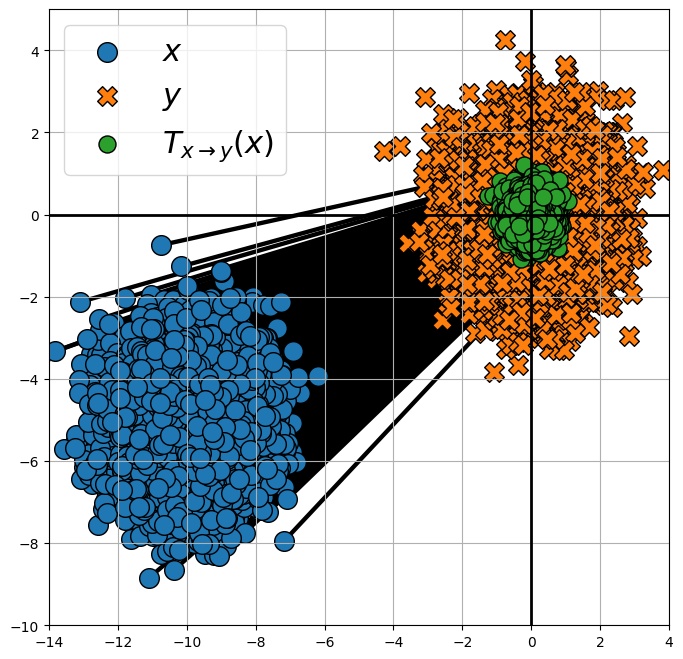

In [18]:
plot_map(datapoints, target, dual_potentials.transport(datapoints))

In [8]:
print(
    "median cost:",
    geom.median_cost_matrix,
    " mean cost:",
    geom.mean_cost_matrix,
)


median cost: 126.98709  mean cost: 129.0025


Concerning the DDPM encoder map, we first transform our clean data (sample from $\mu \sim \mathcal{N}(a,I_2)$) into the gaussian distribution $\mathcal{N}(0,I_2)$ using the forward process: 
$$
q(x_{t}|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t I)
$$
This step is done with the method $\texttt{diffuse}$ from the class $\texttt{DiffusionModel}$ (see the file DDPM.model.py)

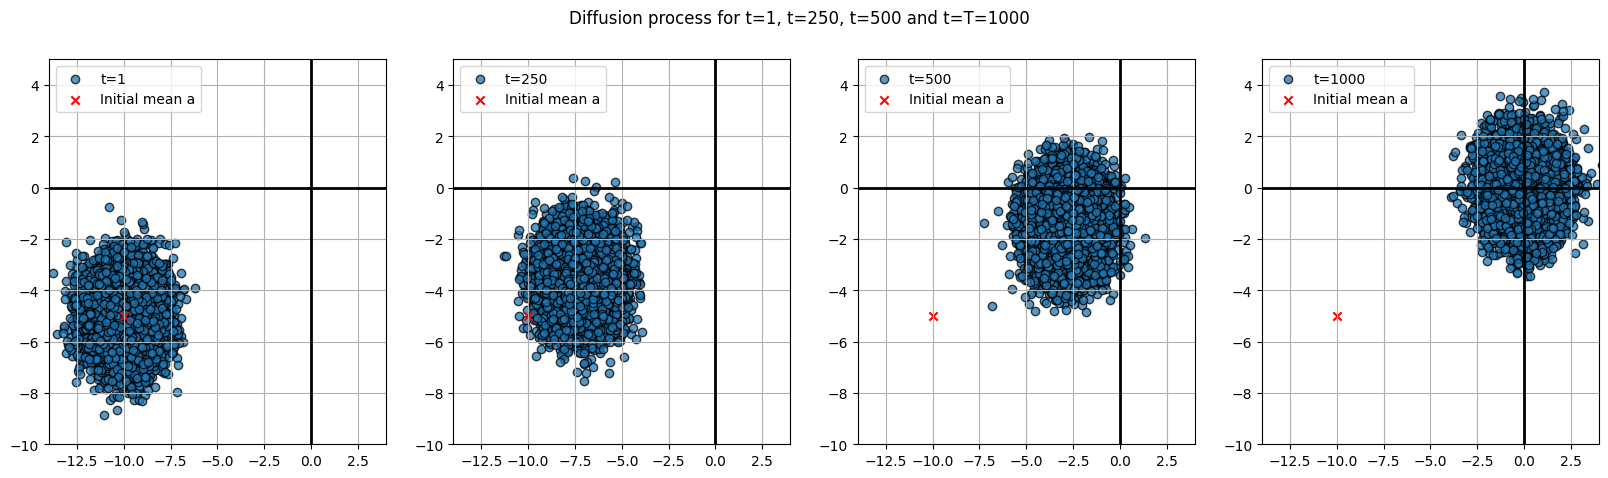

In [9]:
import torch
import numpy as np
from DDPM.model import DiffusionModel, NoiseModel

n_steps = 1000
beta_1 = 0.0001
beta_t = 0.02
device = "cuda" if torch.cuda.is_available() else "cpu"
 
model = NoiseModel(n_steps)
diffuser = DiffusionModel(model, n_steps, beta_1, beta_t, device)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
fig.suptitle("Diffusion process for t=1, t=250, t=500 and t=T=1000")
data_tensor = torch.Tensor(np.array(datapoints))
steps = [1, 250, 500, 1000]
for step, ax in zip(steps, axs):
    t = step * torch.ones([1,], dtype=torch.int32, device=device)
    eps, diffused = diffuser.diffuse(data_tensor, t)
    ax.scatter(diffused[:, 0], diffused[:, 1], label='t='+str(step), edgecolor="k", alpha=0.75)
    ax.set_xlim(-14, 4)
    ax.set_ylim(-10,5)
    ax.axhline(0, color='black', linewidth=2)
    ax.axvline(0, color='black', linewidth=2)
    ax.scatter(-10, -5, color='red', marker='x', label='Initial mean a')
    ax.legend()
    ax.grid(True)

Then, we train a noise predictor network $\epsilon_{\theta}$. All the training process is wrapped into the trainer $\texttt{DiffusionTrainer}$. (see the file DDPM.trainer.py)

100%|██████████| 100/100 [07:49<00:00,  4.69s/it]


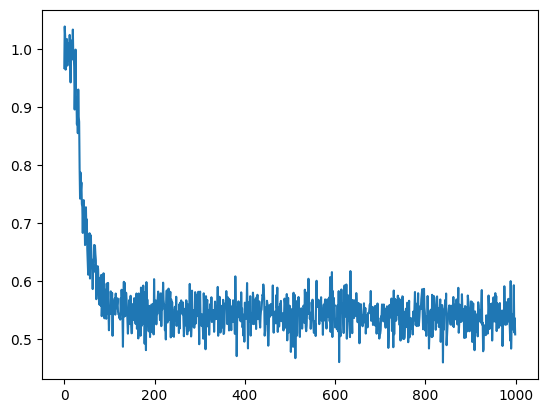

In [10]:
from DDPM.trainer import DiffusionTrainer

# Hyper parameters
batch_size = 1024
n_epochs = 100
lr = 0.003

trainer = DiffusionTrainer(data_tensor, batch_size, beta_1, beta_t, n_steps, lr, device)
all_losses = trainer.train(n_epochs)
plt.figure()
plt.plot(all_losses)
plt.show()

Given a noise $z \sim \mathcal{N}(0,I_2)$ and using the trained noise model, we run the backward process and thus obtain a sample distributed according to the initial distribution $\mathcal{N}(a,I_2)$

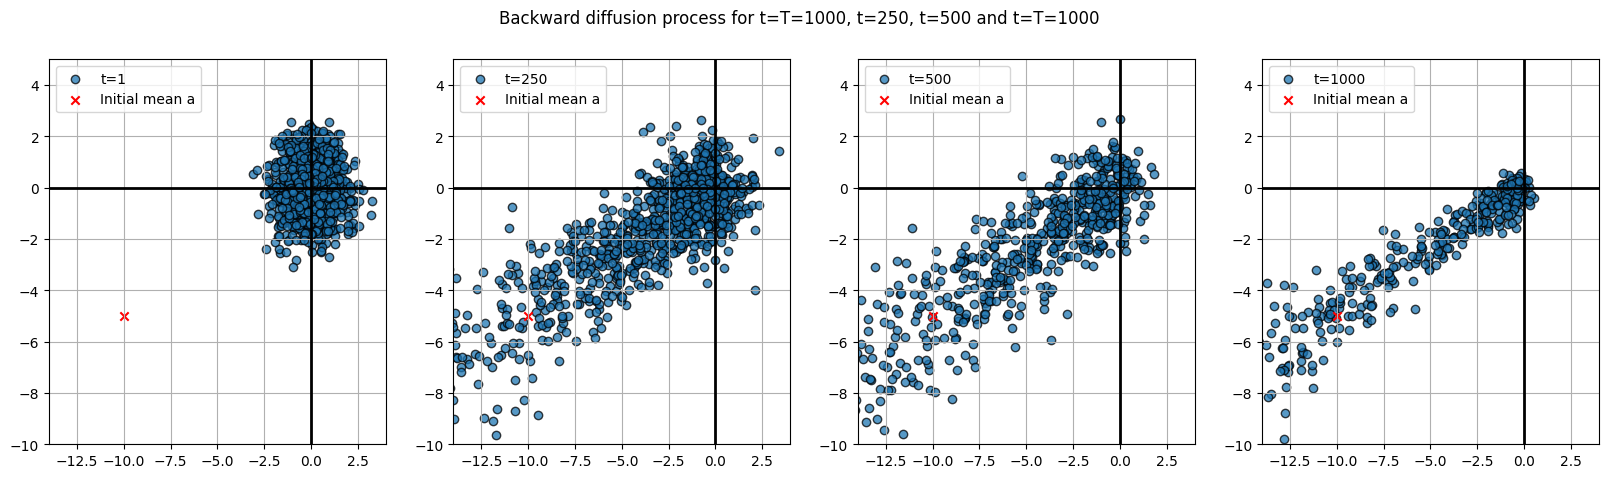

In [16]:
eval_data = torch.randn(1024,2)

trainer.diffuser.model.eval()
with torch.no_grad():
    output, all_outputs = trainer.diffuser.denoise(torch.Tensor(eval_data).to(device), n_steps-1)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
fig.suptitle("Backward diffusion process for t=T=1000, t=250, t=500 and t=T=1000")
data_tensor = torch.Tensor(np.array(datapoints))
steps = [1, 250, 500, 1000]
for step, ax in zip(steps, axs):
    ax.scatter(all_outputs[step-1][:, 0], all_outputs[step-1][:, 1], label='t='+str(step), edgecolor="k", alpha=0.75)
    ax.set_xlim(-14, 4)
    ax.set_ylim(-10,5)
    ax.axhline(0, color='black', linewidth=2)
    ax.axvline(0, color='black', linewidth=2)
    ax.scatter(-10, -5, color='red', marker='x', label='Initial mean a')
    ax.legend()
    ax.grid(True)